# PINN Solution of the Kuramoto-Sivashinsky equation

This PyTorch code demonstrates the application of physically-informed neural networks (PINN) in the solution of a well-known Kuramoto-Sivashinsky equation with periodic boundary condition
\begin{aligned}
  &u_t =  -u_{xx} - u_{xxxx} - uu_x, \quad (t, x) \in [0, T]\times[-L, L]\\
  &u(0, x) = u_0(x), \quad \forall x \in [-L, L] \\
  &u(t, -L) = u(t, L), \quad u_x(t, -L) = u_x(t, L), \quad \forall t \in [0, T]
\end{aligned}

## Libraries and Dependencies

In [1]:
from itertools import chain
from collections import OrderedDict
import time
import numpy as np
import scipy as sp
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
import torch
import torch.optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
np.random.seed(1234)

In [2]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#
print(f"Working on {device}")

Working on mps


In [3]:
xlo = 0
xhi = 32*np.pi
period = xhi - xlo
tlo = 0.0
thi = 10.0
pi_ten = torch.tensor(np.pi).float().to(device)

u0 = lambda x: np.cos(x/16)*(1 + np.sin((x-1)/16))
u0_ten = lambda x: torch.cos(x/16)*(1 + torch.sin((x-1)/16))

## Physics-informed Neural Networks

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        # parameters
        self.depth = len(layers) - 1
        # set up layer order dict
        self.activation = torch.nn.Tanh
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        self.layers[0].weight = torch.load('initial_weight.pt')
    def forward(self, x):
        out = self.layers(x)
        return out

In [5]:
class PhysicsInformedNN():
    def __init__(self, period,  X_BC, X_PDE, layers):
       
        # BC data point
        self.t_BC = torch.tensor(X_BC[:, 0:1]).float().to(device)
        self.x_BC = torch.tensor(X_BC[:, 1:2]).float().to(device)
        N_BC = X_BC.shape[0]
        self.LW_BC = torch.nn.ParameterList([torch.nn.Parameter(torch.ones(N_BC, 1).float(), requires_grad=True).to(device)])        

        self.period = torch.tensor(period).float().to(device)
        # PDE data, gradients will be computed on these points so requires_grad = True
        self.t_PDE = torch.tensor(X_PDE[:, 0:1], requires_grad=True).float().to(device)
        self.x_PDE = torch.tensor(X_PDE[:, 1:2], requires_grad=True).float().to(device)
        N_PDE = X_PDE.shape[0]
        self.LW_PDE = torch.nn.ParameterList([torch.nn.Parameter(torch.ones(N_PDE, 1).float(), requires_grad=True).to(device)])
     
        
        # layers to build Neural Net
        self.layers = layers
        # deep neural networks
        self.dnn = DNN(layers).to(device)    
        # prepare the optimizer
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr = 1e-3)
        # add a learning rate scheduler
        self.optimizer_LW_BC = torch.optim.Adam(self.LW_BC.parameters(), lr = 5e-3)
        self.optimizer_LW_PDE = torch.optim.Adam(self.LW_PDE.parameters(), lr = 5e-3)
       
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=10000, 
            max_eval=5000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )      
        self.scheduler = lr_scheduler.ExponentialLR(self.optimizer_Adam, gamma=0.99)
        self.iter = 0
    # evaluater neural network, no transformation
    def NN_eval(self, t, x): 
        u = self.dnn(torch.cat([t, x], dim = 1))
        u0_torch = u0_ten(x)
        unew = u0_torch*torch.exp(-t) + t * u
        return unew
    # compute the PDE
    def pde_eval(self, t, x):
        """ The pytorch autograd version of calculating residual """
        u    = self.NN_eval(t, x)
        # compute the derivatives for u
        u_t  = torch.autograd.grad(u,   t, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_x  = torch.autograd.grad(u,   x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_xxx = torch.autograd.grad(u_xx, x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_xxxx = torch.autograd.grad(u_xxx, x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        f    = u_t + u_xx + u_xxxx + u * u_x 
       
        return f
    # compute the total loss for the second-order optimizer
    def loss_func(self):
        # reset the gradient
        self.optimizer_LBFGS.zero_grad()

        
        # compute PBC loss
        BC_pred_left = self.NN_eval(self.t_BC, self.x_BC)
        BC_pred_right = self.NN_eval(self.t_BC, self.x_BC + self.period)
        loss_BC = torch.mean(torch.square(self.LW_BC[0] * (BC_pred_left - BC_pred_right)))
        # compute PDE loss
        pde_pred = self.pde_eval(self.t_PDE, self.x_PDE)
        loss_PDE = torch.mean(torch.square(self.LW_PDE[0] * pde_pred))  
        # compute the total loss, it can be weighted
        loss =  loss_BC + loss_PDE
        # backward propagation
        loss.backward()
        # increase the iteration counter
        self.iter += 1
        # output
        # output the progress
        if self.iter % 1000 == 0:
            end_time = time.time()
            print('Iter %5d, Total: %10.4e, Time: %.2f secs' % (self.iter, loss.item(), end_time - self.start_time))
            print('PBC: %10.4e, PDE: %10.4e' % (loss_BC.item(), loss_PDE.item()))
            self.start_time = end_time
        return loss
    #
    def train(self, nIter):
        # start the timer
        start_time = time.time()        
        # start the training with Adam first
        self.dnn.train()
        print('Starting with Adam')
        for epoch in range(nIter):
          
            # compute PBC loss
            BC_pred_left = self.NN_eval(self.t_BC, self.x_BC)
            BC_pred_right = self.NN_eval(self.t_BC, self.x_BC + self.period)
            loss_BC = torch.mean(torch.square(self.LW_BC[0] * (BC_pred_left - BC_pred_right)))             
            # compute PDE loss
            pde_pred = self.pde_eval(self.t_PDE, self.x_PDE)
            loss_PDE = torch.mean(torch.square(self.LW_PDE[0] * pde_pred))   
            # compute the total loss, it can be weighted
            loss =  loss_BC + loss_PDE
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            self.optimizer_LW_BC.zero_grad()
            self.optimizer_LW_PDE.zero_grad()
            loss.backward()
            self.optimizer_Adam.step() 
            self.LW_BC[0].grad.data = -self.LW_BC[0].grad.data
            self.LW_PDE[0].grad.data = -self.LW_PDE[0].grad.data
            self.optimizer_LW_BC.step()
            self.optimizer_LW_PDE.step()
            # output the progress
            if (epoch + 1) % 1000 == 0:
                end_time = time.time()
                print('Iter %5d, Total: %10.4e, Time: %.2f secs' % (epoch + 1, loss.item(), end_time - start_time))
                print('PBC: %10.4e, PDE: %10.4e' % ( loss_BC.item(), loss_PDE.item()))
                print('For BC,  min LW: %10.4e, max LW: %10.4e' %(torch.min(self.LW_BC[0]).item(), torch.max(self.LW_BC[0]).item()))
                print('For PDE, min LW: %10.4e, max LW: %10.4e' %(torch.min(self.LW_PDE[0]).item(), torch.max(self.LW_PDE[0]).item()))

                start_time = end_time
                # change the learning rate
                self.scheduler.step()
                
        print('Starting with L-BFGS')
        self.start_time = time.time()
        self.optimizer_LBFGS.step(self.loss_func)    
   
    def predict(self, X):
        t = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        x = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        u = self.NN_eval(t, x)
        u = u.detach().cpu().numpy()
        return u


## Training

In [6]:
layers = [2, 32, 32, 32, 32, 32, 32, 32, 1]
ptsIC=np.load('ptsIC.npy')
ptsBC=np.load('ptsBC.npy')
ptsPDE=np.load('random_data.npy')
ptsPDE = np.vstack((ptsIC,ptsPDE))
N_IC = 96
x_IC = np.expand_dims(np.linspace(xlo, xhi, N_IC), axis = 1)
u_IC= u0(x_IC)

model = PhysicsInformedNN(period,ptsBC, ptsPDE, layers )
model.train(50000)

Starting with Adam
Iter  1000, Total: 3.1819e-01, Time: 146.22 secs
PBC: 4.8789e-03, PDE: 3.1331e-01
For BC,  min LW: 3.4144e+00, max LW: 6.1576e+00
For PDE, min LW: 2.5383e+00, max LW: 9.0361e+00
Iter  2000, Total: 1.5325e-01, Time: 169.09 secs
PBC: 7.8580e-04, PDE: 1.5247e-01
For BC,  min LW: 3.6927e+00, max LW: 1.0475e+01
For PDE, min LW: 3.1364e+00, max LW: 1.4822e+01
Iter  3000, Total: 2.3054e+00, Time: 199.75 secs
PBC: 1.4238e-03, PDE: 2.3040e+00
For BC,  min LW: 4.1937e+00, max LW: 1.7264e+01
For PDE, min LW: 3.6962e+00, max LW: 1.9966e+01
Iter  4000, Total: 2.9714e-01, Time: 202.38 secs
PBC: 1.1879e-03, PDE: 2.9595e-01
For BC,  min LW: 5.1053e+00, max LW: 2.1326e+01
For PDE, min LW: 4.6932e+00, max LW: 2.4698e+01
Iter  5000, Total: 7.8418e-01, Time: 200.26 secs
PBC: 2.6524e-02, PDE: 7.5765e-01
For BC,  min LW: 5.7105e+00, max LW: 2.4652e+01
For PDE, min LW: 5.2599e+00, max LW: 3.0199e+01
Iter  6000, Total: 4.6833e-01, Time: 200.34 secs
PBC: 1.7191e-02, PDE: 4.5114e-01
For BC,  

Iter 47000, Total: 8.8792e-01, Time: 200.17 secs
PBC: 1.6316e-02, PDE: 8.7160e-01
For BC,  min LW: 8.2490e+01, max LW: 1.1730e+02
For PDE, min LW: 5.6762e+01, max LW: 2.0954e+02
Iter 48000, Total: 1.5641e+01, Time: 201.08 secs
PBC: 1.0964e-01, PDE: 1.5532e+01
For BC,  min LW: 8.3317e+01, max LW: 1.2059e+02
For PDE, min LW: 6.1092e+01, max LW: 2.1251e+02
Iter 49000, Total: 1.2644e+01, Time: 200.70 secs
PBC: 1.4174e-01, PDE: 1.2503e+01
For BC,  min LW: 8.3530e+01, max LW: 1.2249e+02
For PDE, min LW: 6.1196e+01, max LW: 2.1483e+02
Iter 50000, Total: 9.9303e+00, Time: 200.42 secs
PBC: 1.0844e+00, PDE: 8.8458e+00
For BC,  min LW: 8.3891e+01, max LW: 1.2341e+02
For PDE, min LW: 6.1773e+01, max LW: 2.1889e+02
Starting with L-BFGS
Iter  1000, Total: 6.1030e+00, Time: 260.59 secs
PBC: 6.5854e-03, PDE: 6.0964e+00
Iter  2000, Total: 5.5218e+00, Time: 240.49 secs
PBC: 3.1277e-03, PDE: 5.5186e+00


In [7]:
# apply PINN to the same grid as the quadrature solution for comparison
t = np.linspace(tlo, thi, 101)
x = np.linspace(xlo, xhi, 201)
T, X = np.meshgrid(t, x)
pts_flat = np.hstack((T.flatten()[:, None], X.flatten()[:, None]))
u_pred = model.predict(pts_flat)

u_pred = griddata(pts_flat, u_pred.flatten(), (T, X), method='cubic')


## Visualizations

In [8]:
data = scipy.io.loadmat('/Users/abraham/Desktop/PINN/New_Data/KS_1D_t10.mat')
t = data['t'].flatten()[:,None]
x2 = data['x'].flatten()[:,None]
exact_sol = np.real(data['exact_sol']).T

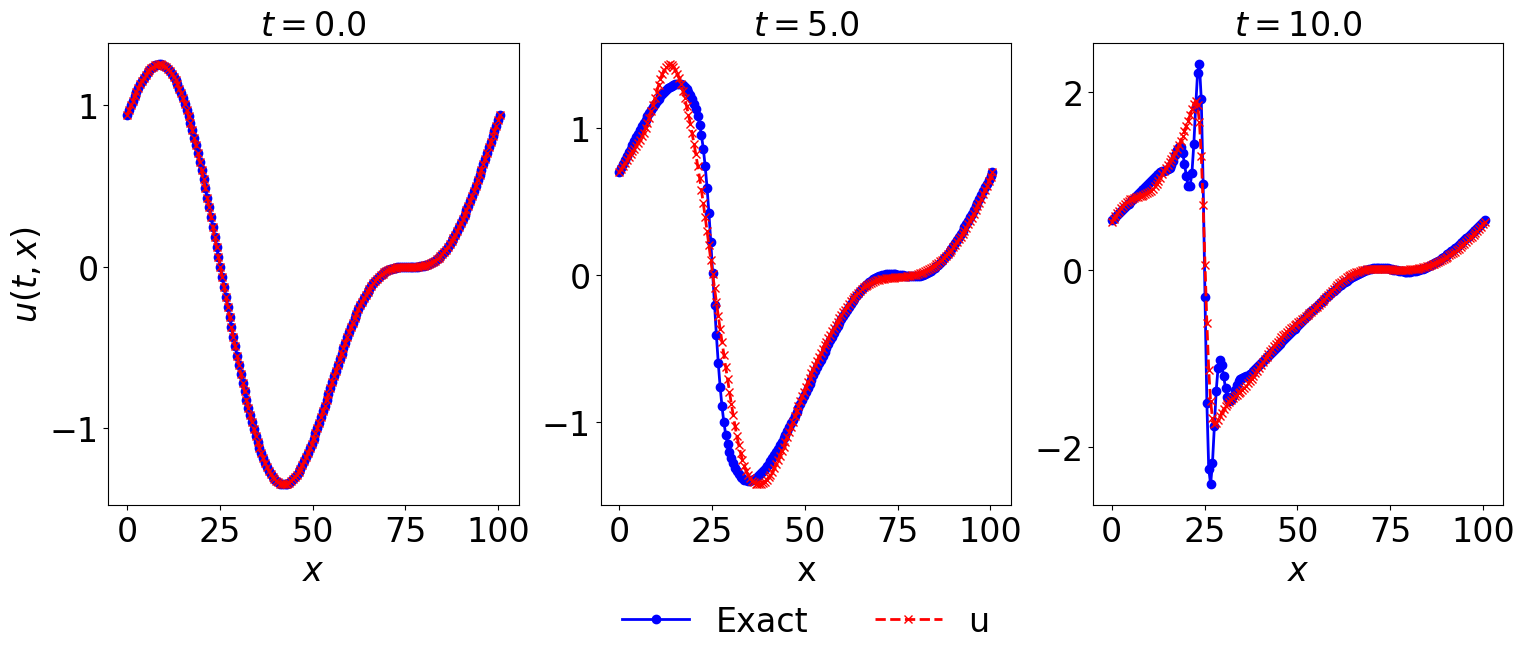

In [13]:
fig = plt.figure(figsize=(18, 6))
#
ax = plt.subplot(1, 3, 1)
ax.plot(x2, exact_sol[0,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 0], 'rx--', linewidth = 2, label = 'u')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = %.1f$' %(t[0]), fontsize = 24)


plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

ax = plt.subplot(1, 3, 2)
ax.plot(x,exact_sol[50,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 50], 'rx--', linewidth = 2, label = 'u')

ax.set_xlabel('x')




ax.set_title('$t = %.1f$' %(t[50]), fontsize = 24)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 24}
)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

ax = plt.subplot(1, 3, 3)
ax.plot(x,exact_sol[100,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 100], 'rx--', linewidth = 2, label = 'u')

ax.set_xlabel('$x$')




ax.set_title('$t = %.1f$' %(t[100]), fontsize = 24)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

plt.show()
fig.savefig('KS_1D_BL+IC1+SA.png',format='png')

In [14]:
def relative_error_l2(pred,exact):
    error_l2 = np.sqrt(np.sum(np.power(pred - exact,2)))
    relative = error_l2/np.sqrt(np.sum(np.power(exact,2)))
    return relative
def relative_error_l1(pred,exact):
    error_l1 = np.sum(np.abs(pred-exact))
    relative = error_l1/np.sum(np.abs(exact))
    return relative
def relative_error_linf(pred,exact):
    error_linf = np.max(np.abs(pred-exact))
    relative = error_linf/np.max(np.abs(exact))
    return relative

In [15]:
print(f'l2: {relative_error_l2(u_pred.T,exact_sol)}')
print(f'l1: {relative_error_l1(u_pred.T,exact_sol)}')
print(f'linf: {relative_error_linf(u_pred.T,exact_sol)}')

l2: 0.20038187269964988
l1: 0.10433035720541058
linf: 0.6237561140171578


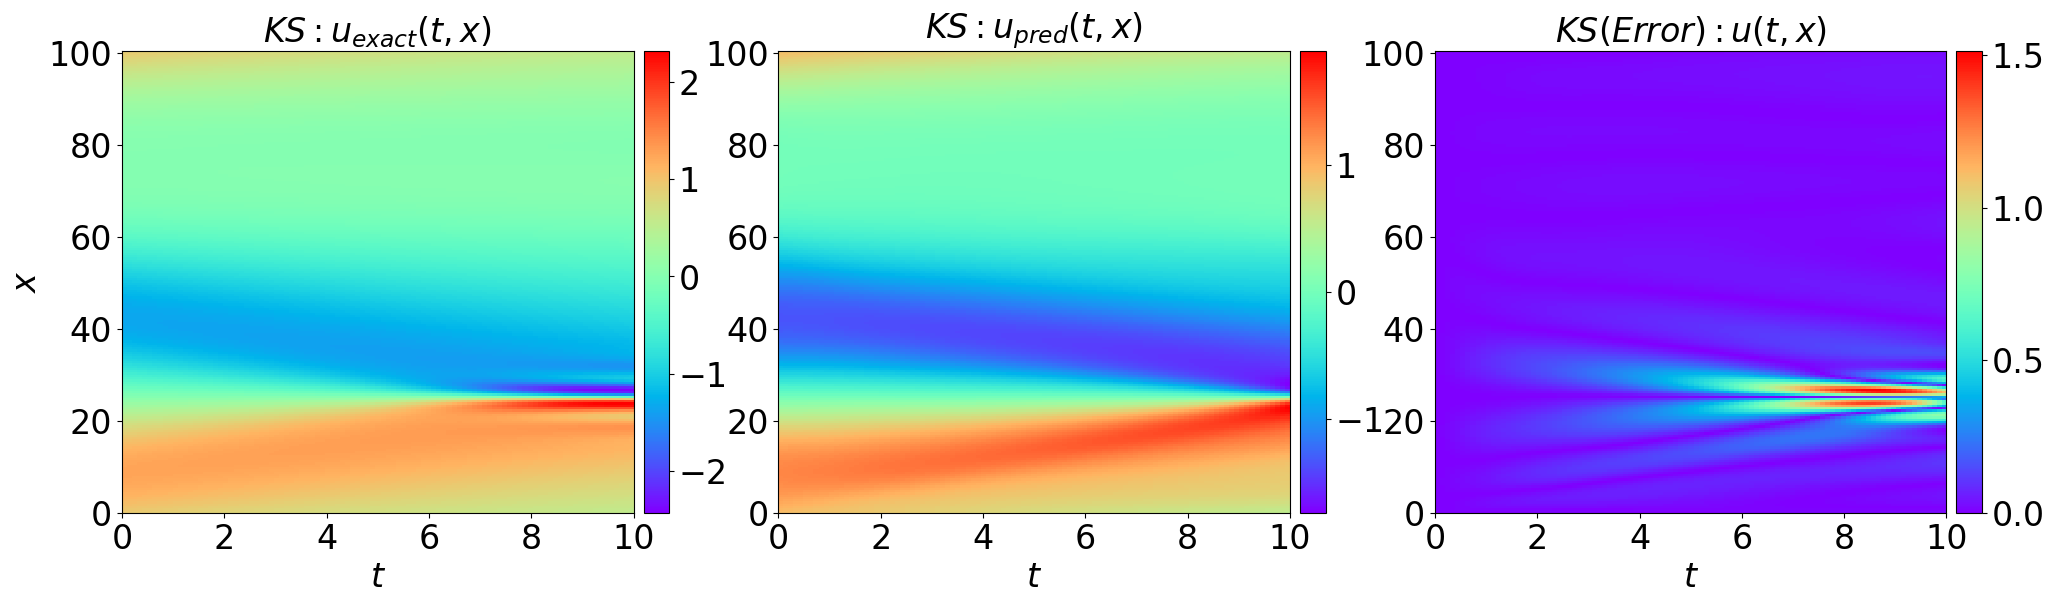

In [16]:
fig = plt.figure(figsize=(24, 6))

ax = plt.subplot(1, 3, 1)
h = ax.imshow(exact_sol.T, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 







ax.set_xlabel('$t$', size=24)
ax.set_ylabel('$x$', size=24)

ax.set_title('$KS: u_{exact}(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)

ax = plt.subplot(1, 3, 2)
h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 




ax.set_xlabel('$t$', size=24)


ax.set_title('$KS: u_{pred}(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)

ax = plt.subplot(1, 3, 3)
h = ax.imshow(np.abs(u_pred-exact_sol.T), interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 




ax.set_xlabel('$t$', size=24)


ax.set_title('$KS(Error): u(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)


plt.show()
fig.savefig('KS3_1D_BL+IC1+SA.png',format='png')